# 따릉이 대여량 예측

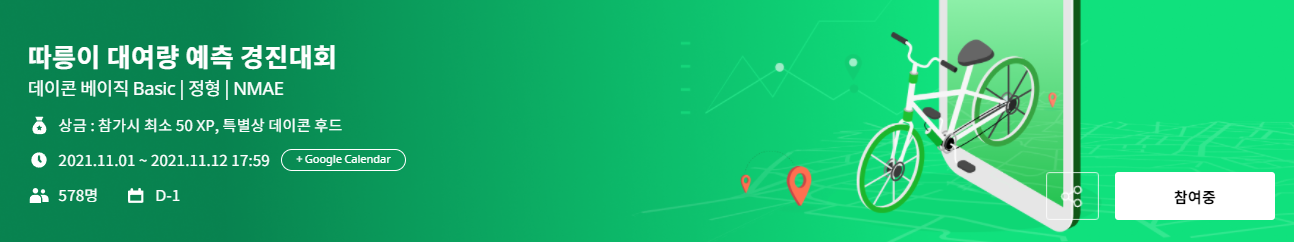

- DACON : [따릉이 대여량 예측](https://dacon.io/competitions/official/235837/overview/description)

무인 공공자전거 대여 서비스인 따릉이는 누구나 손쉽게 이용할 수 있는 자전거 대여 서비스이다. 어플만 있으면 저렴한 가격에 손쉽게 사용이 가능하기 때문에 모두에게나 사랑받고 있다. 따릉이에 대한 수요가 높아 질수록 이에 대한 관리가 필요해 보인다. 자전거의 배치공간은 한계가 있으며 서울에도 지역에 따라 수요가 다르므로 데이터 분석을 통해 따릉이의 대여량을 파악하는 것이 이번 대회의 핵심이다. 데이콘은 서울에 일별, 온도, 습도, 강수량 등 일기예보 데이터와 따릉이의 대여량 데이터를 제공하고, 이 데이터를 통해 따릉이의 대여량을 예측해 보려 한다. 데이콘에서 제공하는 데이터는 다음과 같다.

### Data

기상 데이터는 하루에 총 8번 3시간 간격으로 발표되는 기상단기예보(SHRT) 데이터를 1일 평균으로 변환

- date_time : 일별 날짜
- wind_direction: 풍향 (degree)
- sky_condition : 하늘 상태 
    - 2019년 6월 4일까지 : 맑음(1), 구름조금(2), 구름많음(3), 흐림(4)
    - 2020년 : 맑음(1), 구름많음(3), 흐림(4)
- precipitation_form : 강수 형태 (하단 설명 참조)
    -  precipitation_form (강수 형태) 코드 : 없음(0), 비(1), 진눈깨비(2), 눈(3), 소나기(4)
    - 원본 데이터에는 없음(0), 비(1),소나기(4)가 포함되어있었으며 진눈깨비(2)와 눈(3) 성분은 존재하지 않음.
- wind_speed : 풍속 (m/s)
- humidity : 습도 (%)
- low_temp : 최저 기온 ( `C)
- high_temp : 최고 기온 ( `C)
- Precipitation_Probability : 강수 확률 (%)
- number_of_rentals : 따릉이 대여량

# 1. 라이브러리 및 데이터
우선 라이브러리를 불러와보자. 
- 데이터 전처리를 위해 pandas,numpy를 불러왔고, 
- 데이터 시각화를 위해 matplotlib,seaborn을 불러왔으며,
- sklearn은 머신러닝 라이브러리 이다.

In [55]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [56]:
# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')
# 한글폰트
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
    print('Mac version')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
    print('Windows version')
elif platform.system() == 'Linux':
    path = "/usr/share/fonts/NanumFont/NanumGothicBold.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.rc('font', family=font_name)
    print('Linux version')
else:
    print('Unknown system... sorry~~~~')

Linux version


In [57]:
train = pd.read_csv('data/train.csv', parse_dates=["date_time"])

# 2. 탐색적 자료분석

In [58]:
train.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833


### 2-1. 데이터크기

- 273개의 행과과 10개의 컬럼을 가지고 있다.

In [59]:
train.shape

(273, 10)

### 2-2 컬럼별 자료형
- date_time는 날짜형이고 number_of_rentals는 int64로 포현되있으며 나머지는 float64로 되어있음을 알 수 있다.

In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date_time                  273 non-null    datetime64[ns]
 1   wind_direction             273 non-null    float64       
 2   sky_condition              273 non-null    float64       
 3   precipitation_form         273 non-null    float64       
 4   wind_speed                 273 non-null    float64       
 5   humidity                   273 non-null    float64       
 6   low_temp                   273 non-null    float64       
 7   high_temp                  273 non-null    float64       
 8   Precipitation_Probability  273 non-null    float64       
 9   number_of_rentals          273 non-null    int64         
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 21.5 KB


### 2-3 결측치 파악
- 결측치를 파악을 했으나 다행이 결측치는 없는걸로 판단 되었다.

In [61]:
train.isnull().sum()

date_time                    0
wind_direction               0
sky_condition                0
precipitation_form           0
wind_speed                   0
humidity                     0
low_temp                     0
high_temp                    0
Precipitation_Probability    0
number_of_rentals            0
dtype: int64

### 2-4 데이터 전처리

#### 날짜
date_time를 나누어 year(년),month(월),day(일),weekday(평일,주말)로 나누어 주자.

In [62]:
train["year"] = train["date_time"].dt.year
train["month"] = train["date_time"].dt.month
train["day"] = train["date_time"].dt.day
train["weekday"] = train["date_time"].dt.weekday
train.shape

(273, 14)

#### 요일 한글 ㅁㄴㅇ러민러ㅡ

요일에 대해 컬럼 추가

In [198]:
dateDict = {0: '월요일', 1:'화요일', 2:'수요일', 3:'목요일', 4:'금요일', 5:'토요일', 6:'일요일'}
# dateDict[train.weekday()]
# train['weekday'][0]
# dateDict[train['weekday']]
dateDict[train.weekday]

TypeError: unhashable type: 'Series'

칼럼 10개에서 14개로 늘어난걸 확인 할 수 있다.

In [63]:
train.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals,year,month,day,weekday
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994,2018,4,1,6
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139,2018,4,2,0
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817,2018,4,3,1
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034,2018,4,4,2
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833,2018,4,5,3


## 2. 시각화

### 2-1.Barplot

- 년도별 그래프를 보면 매년마다 대여량이 많아지는걸 볼 수 있다.
- 4,5,6월 그래프를 보면 날씨가 따뜻해질수록 대여량이 많아지는걸 볼 수 있다.
- 일별 그래프는 특징을 찾기 어려운거 같다.
- 요일별 그래프는 대여량이 월~토는 비슷하며 일요일은 미미하게 적은걸 확인 할 수 있다.

ValueError: Unrecognized character n in format string

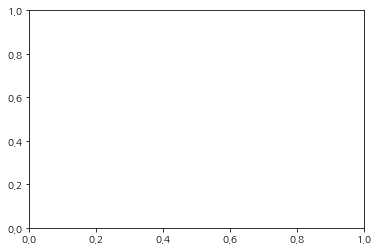

In [166]:
plt.plot('day','month')

[Text(0.5, 0, '요일'), Text(0, 0.5, '대여량'), Text(0.5, 1.0, '요일별 대여량')]

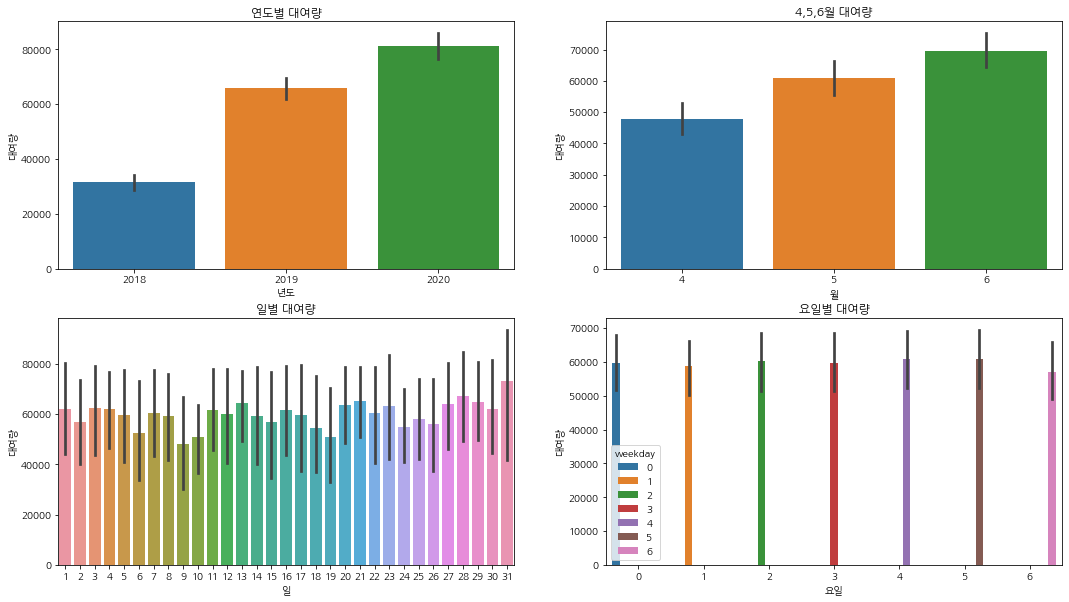

In [73]:
figure, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(18,10)


sns.barplot(data=train, x="year", y="number_of_rentals", ax=ax1)
sns.barplot(data=train, x="month", y="number_of_rentals", ax=ax2)
sns.barplot(data=train, x="day", y="number_of_rentals", ax=ax3)
sns.barplot(data=train, x="weekday", y="number_of_rentals", hue = "weekday",ax=ax4,)

ax1.set(ylabel='대여량',xlabel='년도', title="연도별 대여량",)
ax2.set(xlabel='월',ylabel='대여량',title="4,5,6월 대여량")
ax3.set(xlabel='일',ylabel='대여량',title="일별 대여량")
ax4.set(xlabel='요일',ylabel='대여량', title="요일별 대여량")

<AxesSubplot:>

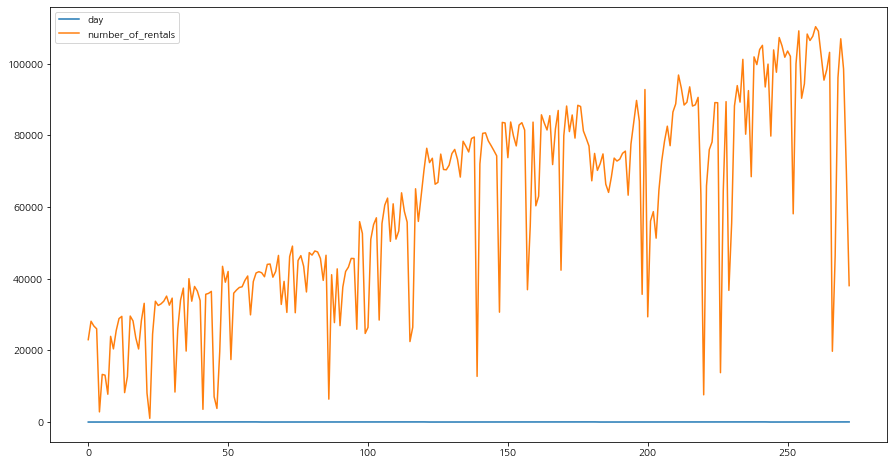

In [203]:
fig, ax = plt.subplots(figsize=(15, 8))
train[['day','number_of_rentals']].plot(ax=ax)
# train
# train['day']

In [224]:
# train.groupby(train['year']).mean()
# train.groupby(['year', 'month', 'day'])['number_of_rentals'].mean()
grouped_df = train.groupby(['month', 'day'])['number_of_rentals'].mean()
# train.groupby(train['year']).sum()
# train.groupby(train[['year', 'month']]).mean()

train.groupby(['year', 'month'])['number_of_rentals'].describe()
# train.groupby(['year', 'month'])['number_of_rentals'].describe()


In [267]:
grouped_df = train.groupby(['year','month', 'day'])['number_of_rentals'].mean()

In [268]:
grouped_df = grouped_df.reset_index()

In [275]:
grouped_df_2018 = grouped_df[grouped_df['year'] == 2018]
grouped_df_2019 = grouped_df[grouped_df['year'] == 2019]
grouped_df_2020 = grouped_df[grouped_df['year'] == 2020]

In [276]:
grouped_df_2020

,year,month,day,number_of_rentals
182,2020,4,1,70258.0
183,2020,4,2,72129.0
184,2020,4,3,74856.0
185,2020,4,4,66405.0
186,2020,4,5,64111.0
...,...,...,...,...
268,2020,6,26,96150.0
269,2020,6,27,107001.0
270,2020,6,28,98568.0
271,2020,6,29,70053.0


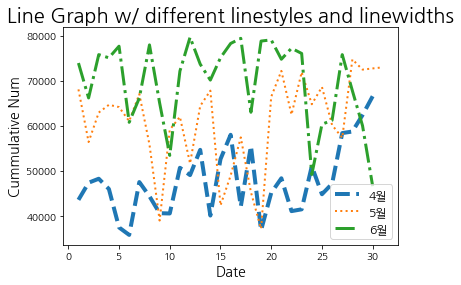

In [265]:


long_df_sub = grouped_df[grouped_df['month'] == 4]
plt.plot(long_df_sub.day, long_df_sub.number_of_rentals, 
         linewidth=4,
         linestyle = '--')

long_df_sub = grouped_df[grouped_df['month'] == 5]
plt.plot(long_df_sub.day, long_df_sub.number_of_rentals, 
         linewidth=2,
        linestyle=':')

long_df_sub = grouped_df[grouped_df['month'] == 6]
plt.plot(long_df_sub.day, long_df_sub.number_of_rentals, 
         linewidth=3,
        linestyle='-.')
    
plt.legend(['4월', '5월', '6월'], fontsize=12, loc='best')
plt.title('Line Graph w/ different linestyles and linewidths', fontsize=20) 
plt.ylabel('Cummulative Num', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.show()





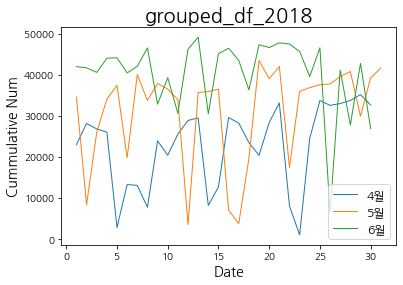

In [278]:
# Line graph with long-form DataFrame

groups = [4, 5, 6]

linewidths = [1, 1, 1]

for group_name, size in zip(groups, linewidths):

    # subsetting
    long_df_sub = grouped_df_2018[grouped_df_2018['month'] == group_name]

    # plotting
    plt.plot(long_df_sub.day, long_df_sub.number_of_rentals, linewidth=size)

plt.legend(['4월', '5월', '6월'], fontsize=12, loc='best')
plt.title('grouped_df_2018', fontsize=20) 
plt.ylabel('Cummulative Num', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.show()



In [350]:
# plt.ylim([0, 20]) 
# grouped_df_2018['number_of_rentals'].min()
# grouped_df_2018['number_of_rentals'].max()




110377.0

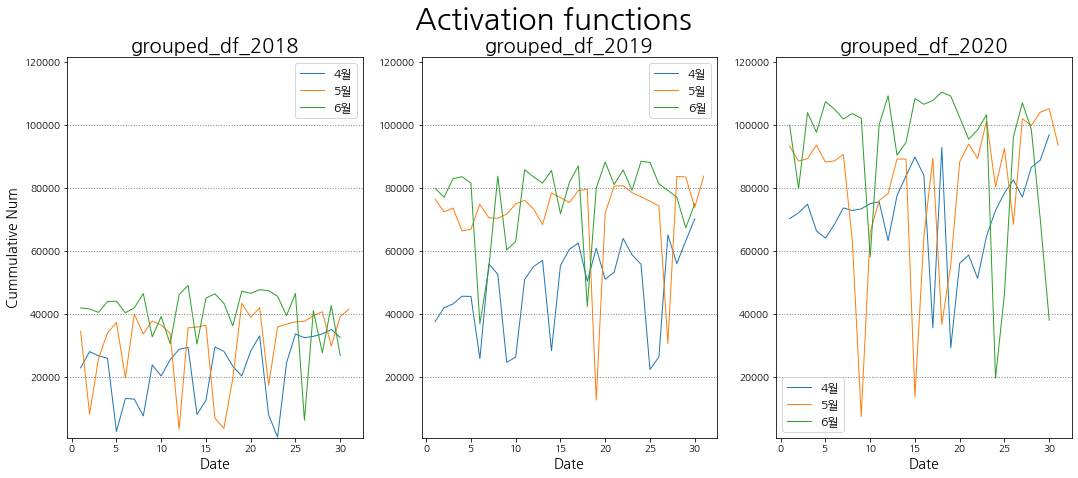

In [365]:
# figure, (ax1,ax2, ax3) = plt.subplots(nrows=1, ncols=3)
# figure, ((ax1,ax2,ax3)) = plt.subplots(nrows=1, ncols=3)
# fig = plt.subplots(ncols=3, figsize=(18, 5), sharey=True)
# figure.set_size_inches(18,5)
# figure.set_size_inches(18,10)


min_value = grouped_df['number_of_rentals'].min()
max_value =  grouped_df['number_of_rentals'].max()

fig = plt.figure()
fig.set_size_inches(18,7)
plt.suptitle('Activation functions', fontsize=30)
# plt.title('grouped_df_2020', fontsize=20) 

ax1 = fig.add_subplot(1,3,1)
# plt.show()


# Line graph with long-form DataFrame

groups = [4, 5, 6]

linewidths = [1, 1, 1]

for group_name, size in zip(groups, linewidths):
    # subsetting
    long_df_sub = grouped_df_2018[grouped_df_2018['month'] == group_name]
    # plotting
    plt.plot(long_df_sub.day, long_df_sub.number_of_rentals, linewidth=size)

# y축 범위
plt.ylim([min_value*0.8, max_value*1.1]) 

# 가로선
plt.axhline(y=20000, color='gray', linewidth=1,linestyle=':')
plt.axhline(y=40000, color='gray', linewidth=1,linestyle=':')
plt.axhline(y=60000, color='gray', linewidth=1, linestyle=':')
plt.axhline(y=80000, color='gray', linewidth=1, linestyle=':')
plt.axhline(y=100000, color='gray', linewidth=1, linestyle=':')

plt.legend(['4월', '5월', '6월'], fontsize=12, loc='best')
plt.title('grouped_df_2018', fontsize=20) 
plt.ylabel('Cummulative Num', fontsize=14)
plt.xlabel('Date', fontsize=14)
# ax1.set()
# plt.show()

ax2 = fig.add_subplot(1,3,2)


# Line graph with long-form DataFrame

groups = [4, 5, 6]

linewidths = [1, 1, 1]

for group_name, size in zip(groups, linewidths):
    # subsetting
    long_df_sub = grouped_df_2019[grouped_df_2019['month'] == group_name]
    # plotting
    plt.plot(long_df_sub.day, long_df_sub.number_of_rentals, linewidth=size)

# y축 범위
plt.ylim([min_value*0.8, max_value*1.1]) 

# 가로선
plt.axhline(y=20000, color='gray', linewidth=1,linestyle=':')
plt.axhline(y=40000, color='gray', linewidth=1,linestyle=':')
plt.axhline(y=60000, color='gray', linewidth=1, linestyle=':')
plt.axhline(y=80000, color='gray', linewidth=1, linestyle=':')
plt.axhline(y=100000, color='gray', linewidth=1, linestyle=':')

plt.legend(['4월', '5월', '6월'], fontsize=12, loc='best')
plt.title('grouped_df_2019', fontsize=20) 
# plt.ylabel('Cummulative Num', fontsize=14)
plt.xlabel('Date', fontsize=14)
# ax2.set()
# plt.show()

ax3 = fig.add_subplot(1,3,3)
# ax3 = fig.add_subplot(1,2,3)
# Line graph with long-form DataFrame

groups = [4, 5, 6]

linewidths = [1, 1, 1]

for group_name, size in zip(groups, linewidths):
    # subsetting
    long_df_sub = grouped_df_2020[grouped_df_2020['month'] == group_name]
    # plotting
    plt.plot(long_df_sub.day, long_df_sub.number_of_rentals, linewidth=size)

# y축 범위
plt.ylim([min_value*0.8, max_value*1.1]) 

# 가로선
plt.axhline(y=20000, color='gray', linewidth=1,linestyle=':')
plt.axhline(y=40000, color='gray', linewidth=1,linestyle=':')
plt.axhline(y=60000, color='gray', linewidth=1, linestyle=':')
plt.axhline(y=80000, color='gray', linewidth=1, linestyle=':')
plt.axhline(y=100000, color='gray', linewidth=1, linestyle=':')



plt.legend(['4월', '5월', '6월'], fontsize=12, loc='best')
plt.title('grouped_df_2020', fontsize=20) 
# plt.ylabel('Cummulative Num', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.show()



In [360]:
grouped_df[grouped_df['number_of_rentals'] < 20000]

,year,month,day,number_of_rentals
4,2018,4,5,2833.0
5,2018,4,6,13297.0
6,2018,4,7,13088.0
7,2018,4,8,7758.0
13,2018,4,14,8216.0
14,2018,4,15,12721.0
21,2018,4,22,8095.0
22,2018,4,23,1037.0
31,2018,5,2,8374.0
35,2018,5,6,19809.0


In [218]:
train[['year', 'day','wind_direction']], # ['year', 'day']

(     year  day  wind_direction
 0    2018    1         207.500
 1    2018    2         208.317
 2    2018    3         213.516
 3    2018    4         143.836
 4    2018    5          95.905
 ..    ...  ...             ...
 268  2020   26         228.662
 269  2020   27         207.770
 270  2020   28         282.568
 271  2020   29         137.027
 272  2020   30         120.797
 
 [273 rows x 3 columns],)

### Heatmap

- 따릉이 대여량의 상관분석을 살펴 보면 풍속,강수,풍속,습도,강수확률은 음의 상관 관계,풍향,온도는 양의 상관관계를 보이고 있습니다. <br> 좀더 자세하게 그래프로 확인해 보겠습니다.

In [11]:
corrMatt = train[["wind_direction",'sky_condition','precipitation_form','wind_speed','humidity','Precipitation_Probability',
                  'low_temp','high_temp','number_of_rentals']]
corrMatt = corrMatt.corr()

<AxesSubplot:>

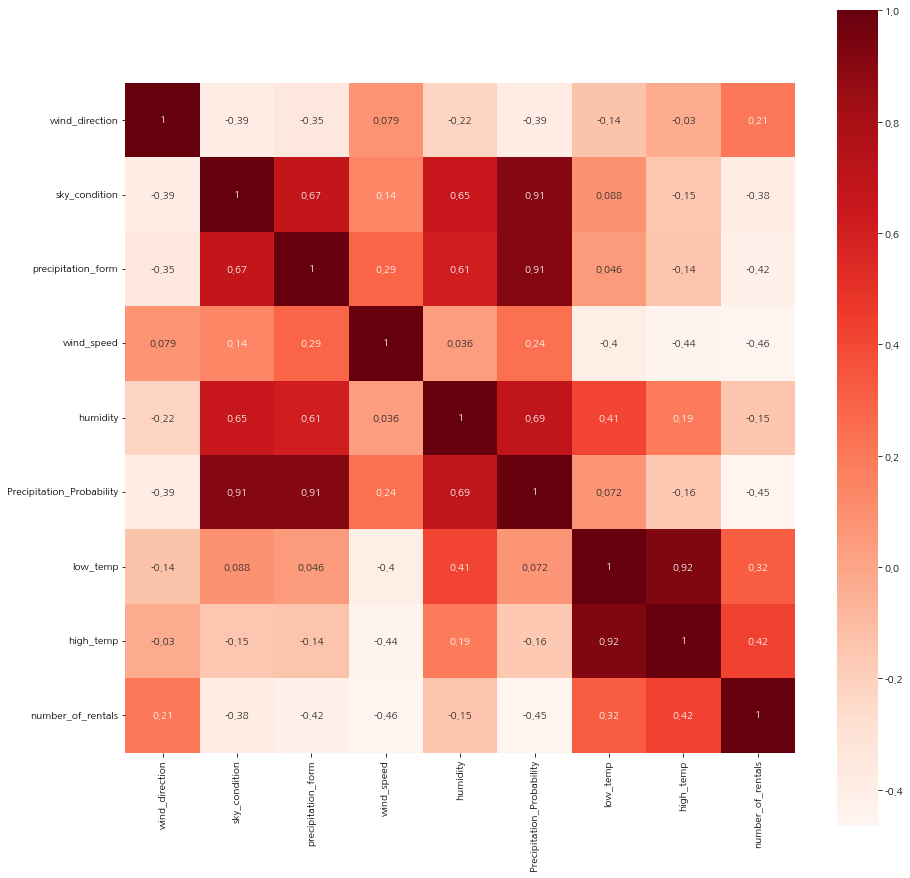

In [84]:
fig, ax = plt.subplots()
fig.set_size_inches(15,15)
sns.heatmap(corrMatt,annot=True, square=True, cmap ='Reds')

### Regplot
- 날씨별 대여량을 확인하면 맑음(1)때 대여량이 많고, 날씨가 흐림(4)으로 갈때 대여량이 낮아지는 것을 볼 수 있다.
- 강수량별 대여량을 확인하면 0 ~ 1(없음~비) 비가 안올때 대여량이 많은걸 확인 할 수 있다.
- 강수확률별 대여량 확인하면 강수확률이 낮을때 대여량이 많은것을 확인 할 수 있다.

[Text(0.5, 0, '요일'), Text(0, 0.5, '대여량'), Text(0.5, 1.0, '요일별 대여량')]

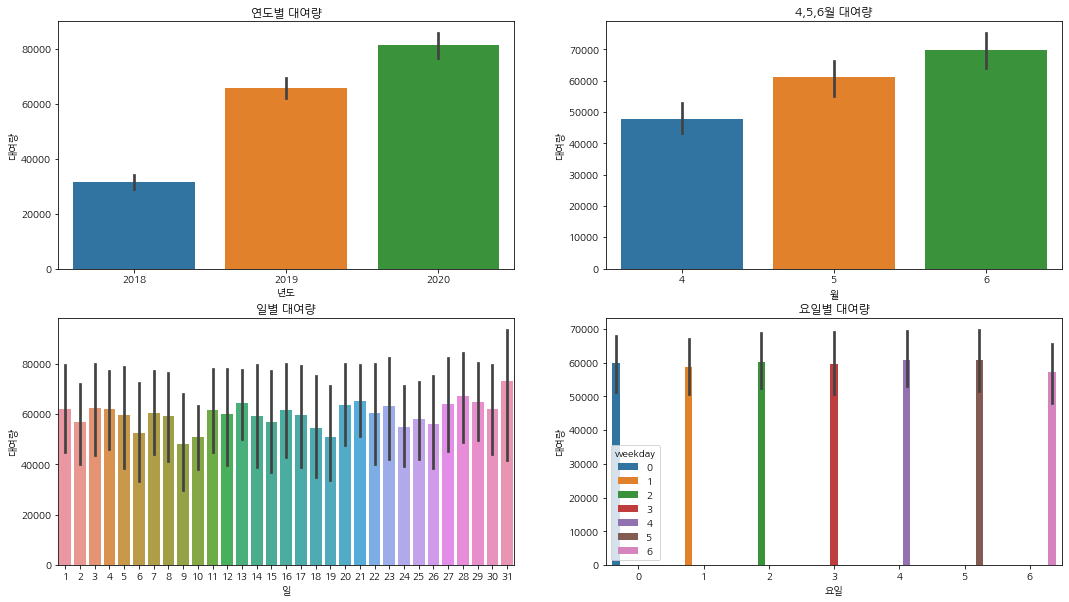

In [310]:
figure, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(18,10)


sns.barplot(data=train, x="year", y="number_of_rentals", ax=ax1)
sns.barplot(data=train, x="month", y="number_of_rentals", ax=ax2)
sns.barplot(data=train, x="day", y="number_of_rentals", ax=ax3)
sns.barplot(data=train, x="weekday", y="number_of_rentals", hue = "weekday",ax=ax4,)

ax1.set(ylabel='대여량',xlabel='년도', title="연도별 대여량",)
ax2.set(xlabel='월',ylabel='대여량',title="4,5,6월 대여량")
ax3.set(xlabel='일',ylabel='대여량',title="일별 대여량")
ax4.set(xlabel='요일',ylabel='대여량', title="요일별 대여량")

[Text(0.5, 0, '강수확률'), Text(0, 0.5, '대여량'), Text(0.5, 1.0, '강수확률별 대여량')]

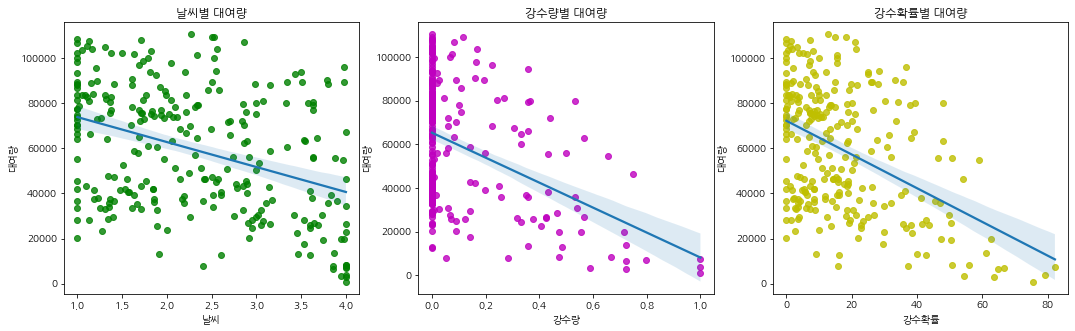

In [157]:
figure, ((ax1,ax2,ax3)) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(18,5)
sns.regplot(data=train, x='sky_condition', y='number_of_rentals', scatter_kws={'color': 'g'}, ax=ax1)
sns.regplot(data=train, x='precipitation_form', y='number_of_rentals', scatter_kws={'color':'m'}, ax=ax2)
sns.regplot(data=train, x='Precipitation_Probability', y='number_of_rentals',scatter_kws={'color':'y'},ax=ax3)

ax1.set(xlabel='날씨',ylabel='대여량', title='날씨별 대여량')
ax2.set(xlabel='강수량',ylabel='대여량', title='강수량별 대여량')
ax3.set(xlabel='강수확률',ylabel='대여량', title='강수확률별 대여량')

### 온도별 대여량
- 최저,최고온도별 대여량을 보면 온도가 높아야 대여량이 증가하는것을 볼 수 있다.

[Text(0.5, 0, '최고온도'), Text(0, 0.5, '대여량'), Text(0.5, 1.0, '최온도별 대여량')]

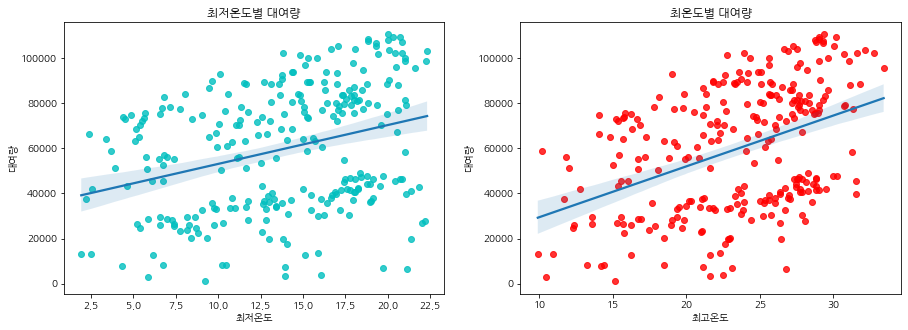

In [159]:
figure, ((ax1,ax2)) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(15,5)

sns.regplot(data=train, x='low_temp', y='number_of_rentals', scatter_kws={'color':'c'}, ax=ax1)
sns.regplot(data=train, x='high_temp', y='number_of_rentals', scatter_kws={'color':'r'}, ax=ax2)

ax1.set(xlabel='최저온도',ylabel='대여량', title='최저온도별 대여량')
ax2.set(xlabel='최고온도',ylabel='대여량', title='최온도별 대여량')

## 3. 변수 및 모델 정의
우리의 목적은 주어진 날시 데이터를 이용해 따릉이 대여량을 예측하는 것입니다.<br>
날시 데이터가 X, 따릉이 대여 수가 y가 되야 한다.

In [18]:
X = train.drop(['date_time', 'number_of_rentals'], axis=1)
y = train.number_of_rentals

In [19]:
X

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,year,month,day,weekday
0,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,2018,4,1,6
1,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,2018,4,2,0
2,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,2018,4,3,1
3,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,2018,4,4,2
4,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2018,4,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...
268,228.662,3.980,0.223,2.271,78.378,20.500,27.526,36.486,2020,6,26,4
269,207.770,2.865,0.081,1.794,78.412,20.812,28.842,21.081,2020,6,27,5
270,282.568,1.730,0.000,1.820,72.736,21.000,29.053,7.297,2020,6,28,6
271,137.027,2.257,0.088,2.043,70.473,19.625,26.000,15.541,2020,6,29,0


## 0.oringinal model성능 확인

In [20]:
def NMAE(true, pred):
    score = np.mean(np.abs(true-pred) / true)
    return score

In [21]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y) 

LinearRegression()

In [22]:
y_hat = model.predict(X)

In [23]:
score = NMAE(y, y_hat)

print(f'모델 NMAE:{score}')

모델 NMAE:0.32188108025106205


오차율이 32%정도로 나왔다.

## 1. Feature Engineering by human
### 요일정보,온도 정보 추가
- 1. 일교차가 너무 큰 날씨
- 2. 너무 덥고 습한 날씨
- 3. 춥고 바람부는 날씨

In [24]:
X_human = X.copy()

In [25]:
# 1. "일교차가 너무 큰 날씨"를 알기 위한 정보
X_human['temp_diff_info'] = X_human['high_temp'] - X_human['low_temp']

# 2. "덥고 습한 날씨"를 알기 위한 정보
X_human['sweat_info'] = X_human['high_temp'] * X_human['humidity']

# 3. "춥고 바람부는 날씨"를 알기 위한 정보
X_human['cold_info'] = X_human['low_temp'] * X_human['wind_speed']

X_human.head()

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,year,month,day,weekday,temp_diff_info,sweat_info,cold_info
0,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,2018,4,1,6,8.400,1575.000000,38.430000
1,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,2018,4,2,0,6.188,1326.827000,41.997736
2,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,2018,4,3,1,5.004,1146.846764,27.739280
3,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,2018,4,4,2,4.056,888.628432,26.083056
4,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2018,4,5,3,4.546,768.903064,18.717750


In [26]:
## 1번 모델 성능 확인
model = LinearRegression() # 모델 정의
model.fit(X_human, y) # 학습

y_hat = model.predict(X_human) # 예측

score = NMAE(y, y_hat)

print(f'모델 NMAE:{score}')

모델 NMAE:0.2818389159815312


오차율이 32%에서 4%가량 성능 향상이되어 28%정도 인것을 확인할 수 있다.

## 2. Feature Engineering by Computer

이번에는 사람의 판단이 들어가지 않고 오로지 컴퓨터의 단순 계산만을 이용해 feature를 추가해보자.<br>
sklearn 에서 제공하는 feature engineering이 이런 방식입니다.<br>
두 변수간의 곱을 추가해준 다음 성능 비교를 해봅시다.

In [27]:
X_computer = X.copy()

In [28]:
col_list = X_computer.columns

# 이중 for문을 사용하여 feature 자기 자신의 제곱과 두 feature간의 곱이라는 새로운 feature를 추가해줍니다.
for i in range(len(col_list)):
    for j in range(i, len(col_list)):
        X_computer[f'{col_list[i]}*{col_list[j]}'] = X_computer[col_list[i]]*X_computer[col_list[j]]
        
X_computer

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,year,month,...,year*year,year*month,year*day,year*weekday,month*month,month*day,month*weekday,day*day,day*weekday,weekday*weekday
0,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,2018,4,...,4072324,8072,2018,12108,16,4,24,1,6,36
1,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,2018,4,...,4072324,8072,4036,0,16,8,0,4,0,0
2,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,2018,4,...,4072324,8072,6054,2018,16,12,4,9,3,1
3,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,2018,4,...,4072324,8072,8072,4036,16,16,8,16,8,4
4,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2018,4,...,4072324,8072,10090,6054,16,20,12,25,15,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,228.662,3.980,0.223,2.271,78.378,20.500,27.526,36.486,2020,6,...,4080400,12120,52520,8080,36,156,24,676,104,16
269,207.770,2.865,0.081,1.794,78.412,20.812,28.842,21.081,2020,6,...,4080400,12120,54540,10100,36,162,30,729,135,25
270,282.568,1.730,0.000,1.820,72.736,21.000,29.053,7.297,2020,6,...,4080400,12120,56560,12120,36,168,36,784,168,36
271,137.027,2.257,0.088,2.043,70.473,19.625,26.000,15.541,2020,6,...,4080400,12120,58580,0,36,174,0,841,0,0


원래 11개만 있던 feature가 90개로 늘어난걸 확인 할 수 있다.

In [29]:
model = LinearRegression()  
model.fit(X_computer, y) 

y_hat = model.predict(X_computer) 

score = NMAE(y, y_hat)

print(f'모델 NMAE: {score}')

모델 NMAE: 0.13254274587645035


기존 모델 32% 보다 19% 줄어든 13% 많이 향상 되었음을 확인 할 수 있다.

## 3. Feature Engineering by Human & Computer

2번에서 컴퓨터로만 한것과 1번에서 추가한 정보를 통해 방식을 혼용해보자.

In [30]:
X_combination = X.copy()

#### 요일정보,온도정보를 추가해주자.

In [31]:
# 요일 정보 추가

# 1. "일교차가 너무 큰 날씨"를 알기 위한 정보
X_combination['temp_diff_info'] = X_combination['high_temp'] - X_combination['low_temp']

# 2. "덥고 습한 날씨"를 알기 위한 정보
X_combination['sweat_info'] = X_combination['high_temp'] * X_combination['humidity'] 

# 3. "춥고 바람부는 날씨"를 알기 위한 정보
X_combination['cold_info'] = X_combination['low_temp'] * X_combination['wind_speed']


In [32]:
col_list = X_combination.columns

# 이중 for문을 사용하여 변수 자기 자신의 제곱과 두 변수간의 곱이라는 새로운 변수를 추가합니다.
for i in range(len(col_list)):
    for j in range(i, len(col_list)):
        X_combination[f'{col_list[i]}*{col_list[j]}'] = X_combination[col_list[i]] * X_combination[col_list[j]]
        
X_combination

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,year,month,...,weekday*weekday,weekday*temp_diff_info,weekday*sweat_info,weekday*cold_info,temp_diff_info*temp_diff_info,temp_diff_info*sweat_info,temp_diff_info*cold_info,sweat_info*sweat_info,sweat_info*cold_info,cold_info*cold_info
0,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,2018,4,...,36,50.400,9450.000000,230.580000,70.560000,13230.000000,322.812000,2.480625e+06,60527.250000,1476.864900
1,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,2018,4,...,0,0.000,0.000000,0.000000,38.291344,8210.405476,259.881990,1.760470e+06,55723.730064,1763.809829
2,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,2018,4,...,1,5.004,1146.846764,27.739280,25.040016,5738.821207,138.807357,1.315258e+06,31812.703504,769.467655
3,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,2018,4,...,4,8.112,1777.256864,52.166112,16.451136,3604.276920,105.792875,7.896605e+05,23178.145155,680.325810
4,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2018,4,...,9,13.638,2306.709192,56.153250,20.666116,3495.433329,85.090891,5.912119e+05,14392.135326,350.354165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,228.662,3.980,0.223,2.271,78.378,20.500,27.526,36.486,2020,6,...,16,28.104,8629.731312,186.222000,49.364676,15158.123050,327.098943,4.654516e+06,100440.364024,2167.414580
269,207.770,2.865,0.081,1.794,78.412,20.812,28.842,21.081,2020,6,...,25,40.150,11307.794520,186.683640,64.480900,18160.317999,299.813926,5.114649e+06,84439.209655,1394.031258
270,282.568,1.730,0.000,1.820,72.736,21.000,29.053,7.297,2020,6,...,36,48.318,12679.194048,229.320000,64.850809,17017.591611,307.785660,4.465610e+06,80766.466086,1460.768400
271,137.027,2.257,0.088,2.043,70.473,19.625,26.000,15.541,2020,6,...,0,0.000,0.000000,0.000000,40.640625,11680.899750,255.598453,3.357316e+06,73463.926975,1607.518813


feature가 135개로 늘어난걸 확인 할 수 있다.

In [33]:
## 3번 모델 성능 확인

model = LinearRegression() # 모델 정의
model.fit(X_combination, y) # 학습

y_hat = model.predict(X_combination) # y 예측

score = NMAE(y, y_hat)

print(f'모델 NMAE: {score}')

모델 NMAE: 0.10106374220842429


결과를 보면 성능이 험청 상향 된걸 확인 할 수 있다. 기존 모델과 오차율이 22%, 2번모델과 4% 정도 차이의 성능을 보여준다.<br>
결과를 보면 컴퓨터만 단순계산보다 정보를 추가해 혼용한것이 성능이 좋은 것을 알 수 있다.

## 4.Submission 제출
### test set 전처리

In [34]:
test = pd.read_csv('data/test.csv', parse_dates=["date_time"])
submission = pd.read_csv('data/sample_submission.csv')

In [35]:
test.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability
0,2021-04-01,108.833,3.000,0.000,2.900,28.333,11.800,20.667,18.333
1,2021-04-02,116.717,3.850,0.000,2.662,46.417,12.000,19.000,28.500
2,2021-04-03,82.669,4.000,0.565,2.165,77.258,8.875,16.368,52.847
3,2021-04-04,44.123,3.466,0.466,3.747,63.288,6.250,17.368,37.671
4,2021-04-05,147.791,1.500,0.000,1.560,48.176,7.188,18.684,4.459


In [36]:
test.isnull().sum()

date_time                    0
wind_direction               0
sky_condition                0
precipitation_form           0
wind_speed                   0
humidity                     0
low_temp                     0
high_temp                    0
Precipitation_Probability    0
dtype: int64

In [37]:
test["year"] = test["date_time"].dt.year
test["month"] = test["date_time"].dt.month
test["day"] = test["date_time"].dt.day
test["weekday"] = test["date_time"].dt.weekday

# date_time은 제거
test_X = test.drop('date_time', axis = 1)

In [38]:
test_X.head()

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,year,month,day,weekday
0,108.833,3.000,0.000,2.900,28.333,11.800,20.667,18.333,2021,4,1,3
1,116.717,3.850,0.000,2.662,46.417,12.000,19.000,28.500,2021,4,2,4
2,82.669,4.000,0.565,2.165,77.258,8.875,16.368,52.847,2021,4,3,5
3,44.123,3.466,0.466,3.747,63.288,6.250,17.368,37.671,2021,4,4,6
4,147.791,1.500,0.000,1.560,48.176,7.188,18.684,4.459,2021,4,5,0


year,month,day,weekday는 잘 추가 되었고 date_time는 잘 제거가 되었다.

#### 요일 정보, 온도정보 추가

In [39]:
# 일교차가 너무 큰 날씨
test_X['temp_diff_info'] = test_X['high_temp'] = test_X['low_temp']

# 덥고 습한 날씨
test_X['sweat_info'] = test_X['high_temp']*test_X['humidity']

# 춥고 바람부는 날씨
test_X['cold_info'] = test_X['low_temp']*test_X['wind_speed']

test_X

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,year,month,day,weekday,temp_diff_info,sweat_info,cold_info
0,108.833,3.000,0.000,2.900,28.333,11.800,11.800,18.333,2021,4,1,3,11.800,334.329400,34.220000
1,116.717,3.850,0.000,2.662,46.417,12.000,12.000,28.500,2021,4,2,4,12.000,557.004000,31.944000
2,82.669,4.000,0.565,2.165,77.258,8.875,8.875,52.847,2021,4,3,5,8.875,685.664750,19.214375
3,44.123,3.466,0.466,3.747,63.288,6.250,6.250,37.671,2021,4,4,6,6.250,395.550000,23.418750
4,147.791,1.500,0.000,1.560,48.176,7.188,7.188,4.459,2021,4,5,0,7.188,346.289088,11.213280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,177.149,3.980,0.223,1.066,74.628,20.312,20.312,36.486,2021,6,26,5,20.312,1515.843936,21.652592
87,138.723,2.777,0.135,1.290,70.236,20.812,20.812,18.378,2021,6,27,6,20.812,1461.751632,26.847480
88,111.095,3.338,1.270,1.692,70.338,21.000,21.000,35.946,2021,6,28,0,21.000,1477.098000,35.532000
89,171.622,3.270,0.595,1.470,70.473,21.000,21.000,27.770,2021,6,29,1,21.000,1479.933000,30.870000


In [40]:
col_list = test_X.columns

for i in range(len(col_list)):
    for j in range(i, len(col_list)):
        test_X[f'{col_list[i]}*{col_list[j]}'] = test_X[col_list[i]]*test_X[col_list[j]]
test_X

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,year,month,...,weekday*weekday,weekday*temp_diff_info,weekday*sweat_info,weekday*cold_info,temp_diff_info*temp_diff_info,temp_diff_info*sweat_info,temp_diff_info*cold_info,sweat_info*sweat_info,sweat_info*cold_info,cold_info*cold_info
0,108.833,3.000,0.000,2.900,28.333,11.800,11.800,18.333,2021,4,...,9,35.400,1002.988200,102.660000,139.240000,3945.086920,403.796000,1.117761e+05,11440.752068,1171.008400
1,116.717,3.850,0.000,2.662,46.417,12.000,12.000,28.500,2021,4,...,16,48.000,2228.016000,127.776000,144.000000,6684.048000,383.328000,3.102535e+05,17792.935776,1020.419136
2,82.669,4.000,0.565,2.165,77.258,8.875,8.875,52.847,2021,4,...,25,44.375,3428.323750,96.071875,78.765625,6085.274656,170.527578,4.701361e+05,13174.619631,369.192207
3,44.123,3.466,0.466,3.747,63.288,6.250,6.250,37.671,2021,4,...,36,37.500,2373.300000,140.512500,39.062500,2472.187500,146.367188,1.564598e+05,9263.286562,548.437852
4,147.791,1.500,0.000,1.560,48.176,7.188,7.188,4.459,2021,4,...,0,0.000,0.000000,0.000000,51.667344,2489.125965,80.601057,1.199161e+05,3883.036505,125.737648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,177.149,3.980,0.223,1.066,74.628,20.312,20.312,36.486,2021,6,...,25,101.560,7579.219680,108.262960,412.577344,30789.822028,439.807449,2.297783e+06,32821.950282,468.834740
87,138.723,2.777,0.135,1.290,70.236,20.812,20.812,18.378,2021,6,...,36,124.872,8770.509792,161.084880,433.139344,30421.974965,558.749754,2.136718e+06,39244.347705,720.787182
88,111.095,3.338,1.270,1.692,70.338,21.000,21.000,35.946,2021,6,...,0,0.000,0.000000,0.000000,441.000000,31019.058000,746.172000,2.181819e+06,52484.246136,1262.523024
89,171.622,3.270,0.595,1.470,70.473,21.000,21.000,27.770,2021,6,...,1,21.000,1479.933000,30.870000,441.000000,31078.593000,648.270000,2.190202e+06,45685.531710,952.956900


In [41]:
# train data로 학습시킨 모델에 test_X데이터를 넣고 예측합니다.
test_yhat = model.predict(test_X)

#submission dataFrame 완성
submission['number_of_rentals'] = test_yhat

# 제출 파일 생성
submission.to_csv('submission.csv', index=False)

# 참고
- Dacon Baseline: [2. Feature Engineering을 이용한 모델 성능 향상](https://dacon.io/competitions/official/235837/codeshare/3687?page=1&dtype=recent)